In [185]:
import pandas as pd
import numpy as np
from datetime import datetime
import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

from warnings import simplefilter

import matplotlib.pyplot as plt

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [186]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [187]:
train_data = pd.read_csv('../data/sales_train_evaluation.csv')
calendar = pd.read_csv('../data/calendar.csv')
price = pd.read_csv('../data/sell_prices.csv')

In [188]:
train_data

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [5]:
price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [7]:
train_data.groupby(['id'])['d_1941'].sum().sort_values(ascending=False)

id
FOODS_3_586_TX_2_evaluation        117
FOODS_3_090_TX_3_evaluation        116
FOODS_3_090_WI_3_evaluation        114
FOODS_3_120_CA_1_evaluation        114
FOODS_3_090_CA_3_evaluation         99
                                  ... 
HOBBIES_1_121_TX_3_evaluation        0
HOBBIES_1_121_TX_2_evaluation        0
HOBBIES_1_121_CA_4_evaluation        0
HOBBIES_1_121_CA_3_evaluation        0
HOUSEHOLD_2_516_WI_3_evaluation      0
Name: d_1941, Length: 30490, dtype: int64

In [8]:
item_id = 'FOODS_3_586_TX_2_evaluation'

In [9]:
day_columns = [column for column in train_data.columns if 'd_' in column]
selected_item = train_data[train_data['id']==item_id]
item_sales = selected_item[day_columns].sum()
item_sales = item_sales.reset_index()
item_sales['store_id'] = selected_item['store_id'].values[0]
item_sales['item_id'] = selected_item['item_id'].values[0]

In [10]:
item_sales

,index,0,store_id,item_id
0,d_1,98,TX_2,FOODS_3_586
1,d_2,85,TX_2,FOODS_3_586
2,d_3,47,TX_2,FOODS_3_586
3,d_4,56,TX_2,FOODS_3_586
4,d_5,51,TX_2,FOODS_3_586
...,...,...,...,...
1936,d_1937,76,TX_2,FOODS_3_586
1937,d_1938,53,TX_2,FOODS_3_586
1938,d_1939,96,TX_2,FOODS_3_586
1939,d_1940,79,TX_2,FOODS_3_586


In [11]:
item_sales = item_sales.rename({'index':'d', 0: 'sales'},axis=1)
item_sales.merge(calendar, how='left', on='d')

,d,sales,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,98,TX_2,FOODS_3_586,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,85,TX_2,FOODS_3_586,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,47,TX_2,FOODS_3_586,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,56,TX_2,FOODS_3_586,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,51,TX_2,FOODS_3_586,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,d_1937,76,TX_2,FOODS_3_586,2016-05-18,11616,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,0,0
1937,d_1938,53,TX_2,FOODS_3_586,2016-05-19,11616,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,0,0
1938,d_1939,96,TX_2,FOODS_3_586,2016-05-20,11616,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,0,0
1939,d_1940,79,TX_2,FOODS_3_586,2016-05-21,11617,Saturday,1,5,2016,NaN,NaN,NaN,NaN,0,0,0


In [12]:
item_sales = item_sales.rename({'index':'d'},axis=1)

merged_item_sales = item_sales.merge(calendar, how='left', on='d')[['date', 'sales', 'store_id', 'item_id', 'wm_yr_wk']]

merged_item_sales['date'] = pd.to_datetime(merged_item_sales['date'])
merged_item_sales.set_index('date', inplace=True)
merged_item_sales.index = merged_item_sales.index.to_period('D')
merged_item_sales

,sales,store_id,item_id,wm_yr_wk
date,,,,
2011-01-29,98,TX_2,FOODS_3_586,11101
2011-01-30,85,TX_2,FOODS_3_586,11101
2011-01-31,47,TX_2,FOODS_3_586,11101
2011-02-01,56,TX_2,FOODS_3_586,11101
2011-02-02,51,TX_2,FOODS_3_586,11101
...,...,...,...,...
2016-05-18,76,TX_2,FOODS_3_586,11616
2016-05-19,53,TX_2,FOODS_3_586,11616
2016-05-20,96,TX_2,FOODS_3_586,11616


In [13]:
merged_item_sales['sell_price'] = merged_item_sales.merge(price, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')['sell_price'].values
merged_item_sales

,sales,store_id,item_id,wm_yr_wk,sell_price
date,,,,,
2011-01-29,98,TX_2,FOODS_3_586,11101,1.48
2011-01-30,85,TX_2,FOODS_3_586,11101,1.48
2011-01-31,47,TX_2,FOODS_3_586,11101,1.48
2011-02-01,56,TX_2,FOODS_3_586,11101,1.48
2011-02-02,51,TX_2,FOODS_3_586,11101,1.48
...,...,...,...,...,...
2016-05-18,76,TX_2,FOODS_3_586,11616,1.68
2016-05-19,53,TX_2,FOODS_3_586,11616,1.68
2016-05-20,96,TX_2,FOODS_3_586,11616,1.68


In [14]:
fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=merged_item_sales.index,
    order=1,
    constant=True,
    seasonal=True,
    drop=True,   
    additional_terms=[fourier]
    )

time_features = dp.in_sample()

In [15]:
def make_lags(ts, lags):
    return pd.DataFrame(
        {
            f'y_lag_{i}': ts.shift(i) for i in range(1, lags+1)
        }
    )

lag_features = make_lags(merged_item_sales.sales, lags=14)
lag_features = lag_features.fillna(0.0)

In [16]:
def make_rolling_mean(ts, lags, window):
        return pd.DataFrame(
        {
            f'y_rolling_mean_{i}': ts.shift(i).rolling(window).mean() for i in range(1, lags+1)
        }
    )

def make_rolling_std(ts, lags, window):
        return pd.DataFrame(
        {
            f'y_rolling_std_{i}': ts.shift(i).rolling(window).std() for i in range(1, lags+1)
        }
    )

    
rolling_mean_features = make_rolling_mean(merged_item_sales.sales, lags=14, window=7)
rolling_mean_features = rolling_mean_features.fillna(0.0)

rolling_std_features = make_rolling_std(merged_item_sales.sales, lags=14, window=7)
rolling_std_features = rolling_std_features.fillna(0.0)

In [17]:
merged_item_sales.sell_price

date
2011-01-29    1.48
2011-01-30    1.48
2011-01-31    1.48
2011-02-01    1.48
2011-02-02    1.48
              ... 
2016-05-18    1.68
2016-05-19    1.68
2016-05-20    1.68
2016-05-21    1.68
2016-05-22    1.68
Freq: D, Name: sell_price, Length: 1941, dtype: float64

In [18]:
def make_price_feature(ts):
    return pd.concat([pd.DataFrame(
        {
            f'price_lag_{i}': ts.shift(i) for i in range(1, 8)
        }),
               pd.DataFrame(
        {
            f'price_rolling_mean_{i}': ts.shift(i).rolling(7).mean() for i in range(1, 8)
        }),
               pd.DataFrame(
        {
            f'price_rolling_std_{i}': ts.shift(i).rolling(7).std() for i in range(1, 8)
        }),
               pd.DataFrame(
        {
            f'price_rolling_max7': ts.rolling(7).max(),
            f'price_rolling_max14': ts.rolling(14).max(),
            f'price_rolling_max28': ts.rolling(28).max(),
            f'price_rolling_min7': ts.rolling(7).min(),
            f'price_rolling_min14': ts.rolling(14).min(),
            f'price_rolling_min28': ts.rolling(28).min(),
            f'price_change_ratio': ts/ts.shift(1)
            
        })
        ], axis=1)
price_features = make_price_feature(merged_item_sales.sell_price)
price_features = price_features.fillna(0)

In [47]:
all_data = pd.concat([time_features, lag_features, rolling_mean_features, rolling_std_features, price_features], axis=1)
all_data['sales'] = merged_item_sales['sales']
all_data.rename({name: re.sub(r'[^a-zA-Z0-9_]', '_', name) for name in all_data.columns}, axis=1, inplace=True)
all_data

,const,trend,s_2_7_,s_3_7_,s_4_7_,s_5_7_,s_6_7_,s_7_7_,sin_1_freq_M_,cos_1_freq_M_,...,price_rolling_std_6,price_rolling_std_7,price_rolling_max7,price_rolling_max14,price_rolling_max28,price_rolling_min7,price_rolling_min14,price_rolling_min28,price_change_ratio,sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.571268,0.820763,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,98
2011-01-30,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.394356,0.918958,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.0,85
2011-01-31,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.201299,0.979530,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.0,47
2011-02-01,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.0,56
2011-02-02,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.222521,0.974928,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,1.0,1937.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.299363,-0.954139,...,0.0,0.0,1.68,1.68,1.68,1.68,1.68,1.68,1.0,76
2016-05-19,1.0,1938.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.485302,-0.874347,...,0.0,0.0,1.68,1.68,1.68,1.68,1.68,1.68,1.0,53
2016-05-20,1.0,1939.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.651372,-0.758758,...,0.0,0.0,1.68,1.68,1.68,1.68,1.68,1.68,1.0,96


In [92]:
X_columns = all_data.columns.drop('sales')
y_column = 'sales'

n_splits = 5  # 指定分割次数
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=90)

y_fore = pd.Series()

lgb_params = {
    #"boosting_type": "goss",
    "n_estimators":1000,
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "metric": "rmse",
    "learning_rate": 0.03,
    #"num_leaves": 2 ** 11 - 1,
    #"min_data_in_leaf": 2 ** 12 - 1,
    "feature_fraction": 0.5,
    #"max_bin": 100,
    "boost_from_average": False,
    #"num_boost_round": 1400,
    "verbose": -1,
    "num_threads": os.cpu_count(),
    "force_row_wise": True,
    "seed": 42
}

for fold, (train_index, test_index) in enumerate(tscv.split(all_data)):
    print(f"Fold {fold + 1}")
    #print('Train index: %s' % train_index)
    #print('Test index: %s' % test_index)
    X_train, X_test = all_data[X_columns].iloc[train_index], all_data[X_columns].iloc[test_index]
    y_train, y_test = all_data[y_column].iloc[train_index], all_data[y_column].iloc[test_index]
    
    train_ds = lgb.Dataset(X_train, label=y_train)
    valid_ds = lgb.Dataset(X_test, label=y_test)

    
    # 在这里训练模型并评估表现
    #model = lgb.LGBMRegressor(lgb_params)
    model = lgb.train(lgb_params, train_ds, valid_sets=[valid_ds], callbacks=[lgb.log_evaluation(period=100,show_stdv=False)])  # 定义模型
    #model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    #y_pred = pd.Series(model.predict(X_train), index=y_train.index)
    y_fore = pd.concat([y_fore, pd.Series(model.predict(X_test), index=y_test.index)])

Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9870
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 77
[LightGBM] [Info] Start training from score 103.531187
[100]	valid_0's l2: 365.375
Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9898
[LightGBM] [Info] Number of data points in the train set: 1581, number of used features: 77
[LightGBM] [Info] Start training from score 102.317521


/var/folders/st/0pg24vg97s98zyv3mbmdmzbc0000gn/T/ipykernel_9150/3438157208.py:46: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_fore = pd.concat([y_fore, pd.Series(model.predict(X_test), index=y_test.index)])


[100]	valid_0's l2: 391.085
Fold 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9902
[LightGBM] [Info] Number of data points in the train set: 1671, number of used features: 77
[LightGBM] [Info] Start training from score 102.641532
[100]	valid_0's l2: 235.432
Fold 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9912
[LightGBM] [Info] Number of data points in the train set: 1761, number of used features: 77
[LightGBM] [Info] Start training from score 102.018171
[100]	valid_0's l2: 505.408
Fold 5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9996
[Lig

In [93]:
#lgb.LGBMRegressor?

In [94]:
#y_fore = y_fore.rename({0: 'sales_fore'}, axis=1)
y_fore

2015-02-28     88.979848
2015-03-01    114.281074
2015-03-02     71.783124
2015-03-03     71.358313
2015-03-04     86.397265
                 ...    
2016-05-18     75.909883
2016-05-19     79.270149
2016-05-20     81.090766
2016-05-21    108.362256
2016-05-22     83.727548
Freq: D, Length: 450, dtype: float64

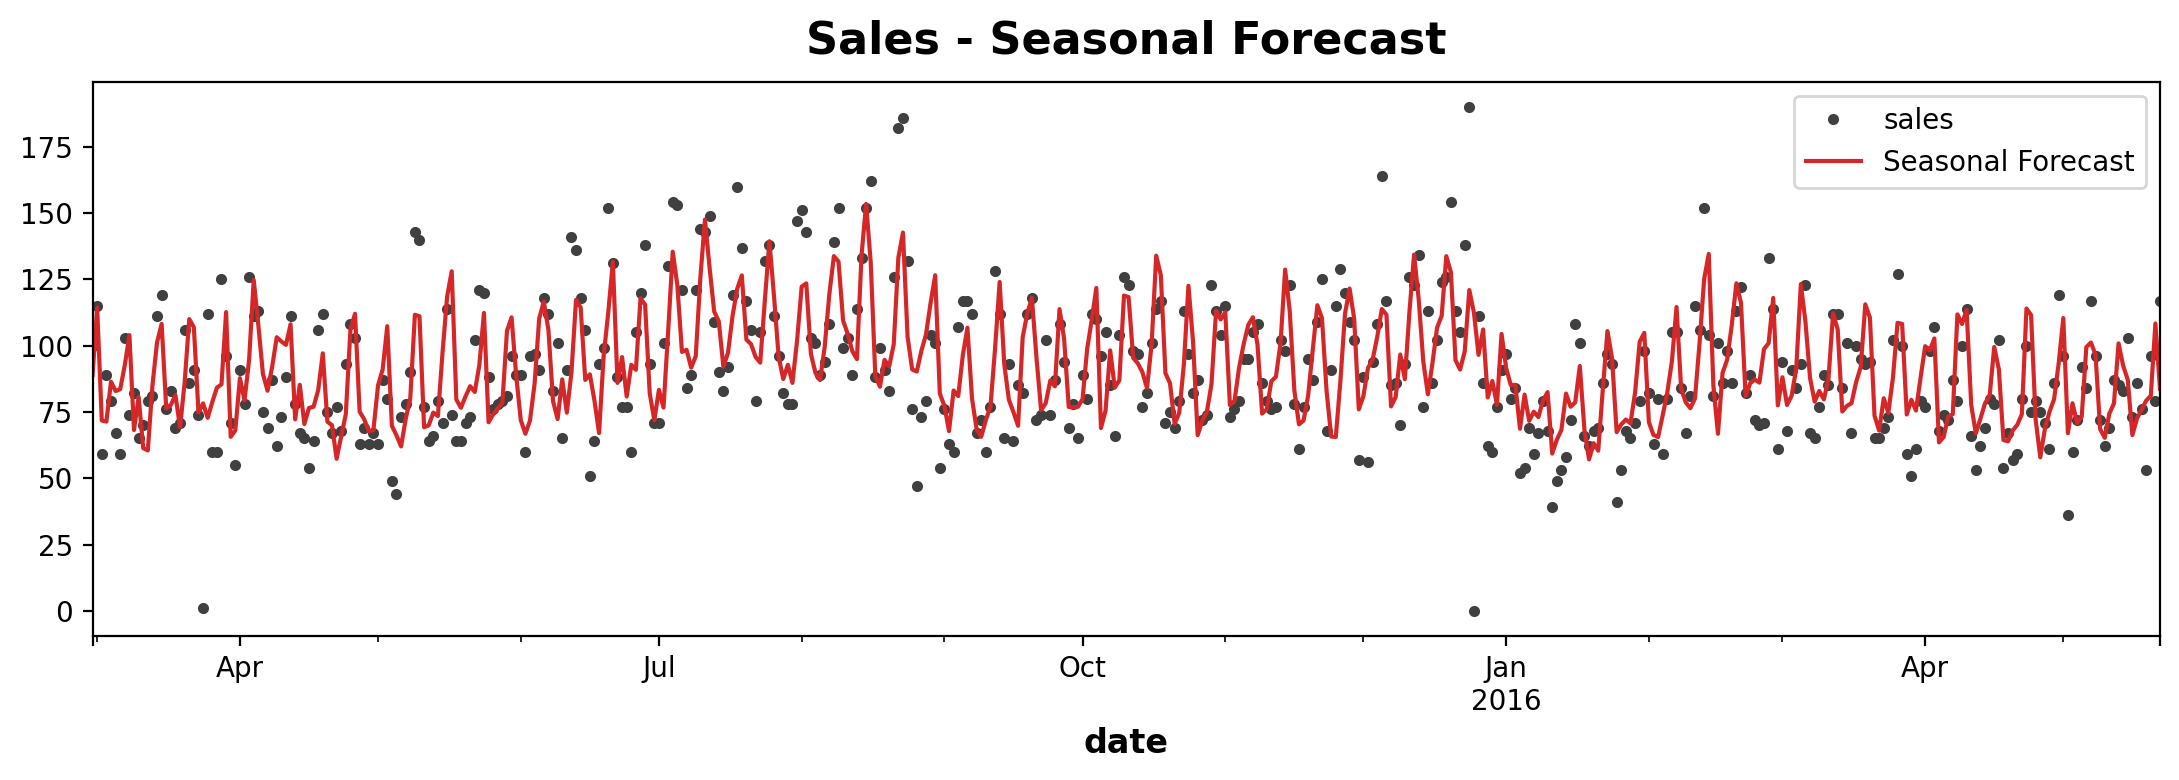

In [95]:
ax = all_data['sales'][-len(y_fore):].plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [96]:
y_residual = y_fore - all_data['sales'][-len(y_fore):]
X = all_data[X_columns][-len(y_fore):]
y_residual

2015-02-28   -11.020152
2015-03-01    -0.718926
2015-03-02    12.783124
2015-03-03   -17.641687
2015-03-04     7.397265
                ...    
2016-05-18    -0.090117
2016-05-19    26.270149
2016-05-20   -14.909234
2016-05-21    29.362256
2016-05-22   -33.272452
Freq: D, Length: 450, dtype: float64

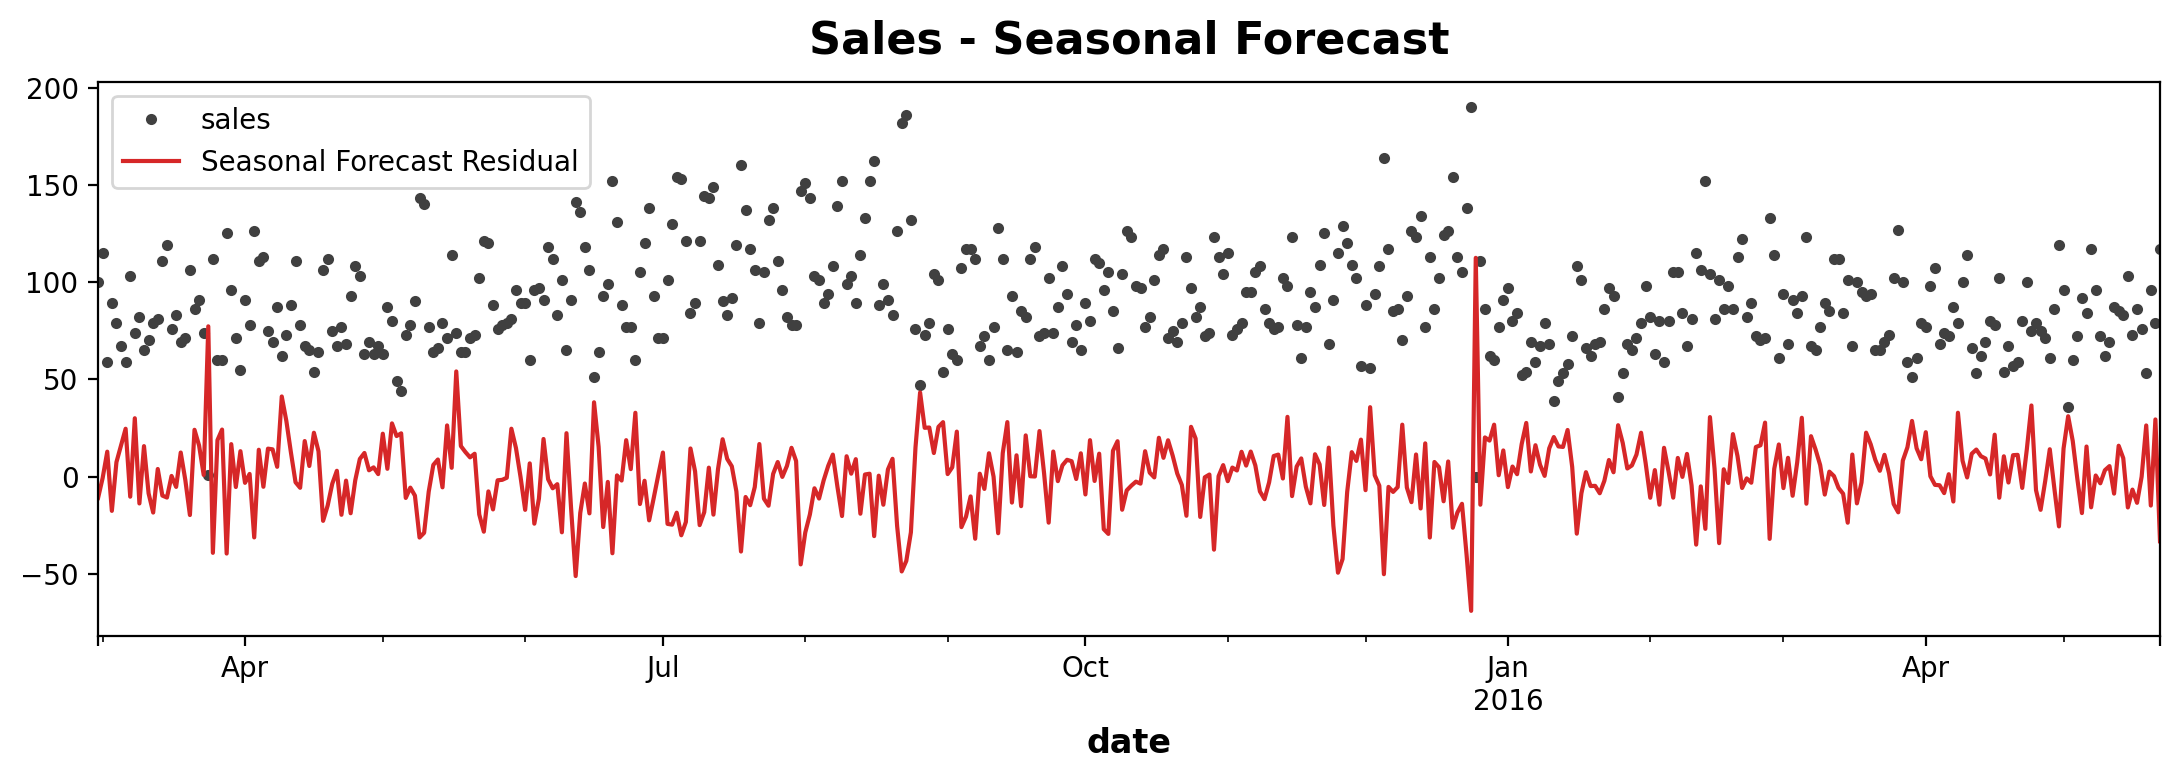

In [97]:
ax = all_data['sales'][-len(y_fore):].plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_residual.plot(ax=ax, label="Seasonal Forecast Residual", color='C3')
_ = ax.legend()

In [98]:
X_train, X_test = X.iloc[:-180], X.iloc[-180:]
y_train, y_test = y_residual.iloc[:-180], y_residual.iloc[-180:]
    
# 在这里训练模型并评估表现
model = XGBRegressor()  # 定义模型
model.fit(X_train, y_train)
y_residual_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [99]:
print('source residuals : %s' % np.mean(y_test**2))

source residuals : 369.60289219338296


In [100]:
print('after xgboost residuals : %s' % mean_squared_error(y_fore[-180:] + y_residual_fore, all_data['sales'][-180:]))

after xgboost residuals : 501.53451544040195


In [71]:
mean_squared_error(y_fore[-180:] + y_residual_fore, all_data['sales'][-180:])/np.mean(y_test**2)

1.274042816657311

* 使用xgboost预测error，并没有减少residual

### MultiOutput Regressor

In [103]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'F{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [104]:
y = make_multistep_target(all_data['sales'], steps=28).dropna()

In [105]:
y, X = y.align(all_data[X_columns], join='inner', axis=0)

In [171]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

lgb_params = {
    #"boosting_type": "goss",
    "n_estimators": 300,
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "metric": "rmse",
    "learning_rate": 0.01,
    "num_leaves": 2 ** 5 - 1,
    #"min_data_in_leaf": 2 ** 12 - 1,
    "feature_fraction": 0.5,
    #"max_bin": 100,
    "boost_from_average": False,
    #"num_boost_round": 1400,
    "verbose": -1,
    #"num_threads": os.cpu_count(),
    "force_row_wise": True,
    "seed": 42
}

model = MultiOutputRegressor(lgb.LGBMRegressor(**lgb_params))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
CPU times: user 41.1 s, sys: 2min 46s, total: 3min 27s
Wall time: 57.1 s


In [172]:
# eval_set不支持MultiOutputRegressor
#model.fit(X_train, y_train, eval_set=[(X_test, y_test.values)], callbacks=[lgb.log_evaluation(period=100,show_stdv=False)])

In [173]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

'''
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = all_data.sales[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Sales (train)', 'Forecast'])
ax2 = all_data.sales[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Sales (test)', 'Forecast'])
'''

Train RMSE: 14.65
Test RMSE: 23.67


"\npalette = dict(palette='husl', n_colors=64)\nfig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))\nax1 = all_data.sales[y_fit.index].plot(**plot_params, ax=ax1)\nax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)\n_ = ax1.legend(['Sales (train)', 'Forecast'])\nax2 = all_data.sales[y_pred.index].plot(**plot_params, ax=ax2)\nax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)\n_ = ax2.legend(['Sales (test)', 'Forecast'])\n"

### Predict

In [174]:
valid_data = all_data[all_data.trend>1913].sales
valid_data

date
2016-04-25     79
2016-04-26     75
2016-04-27     71
2016-04-28     61
2016-04-29     86
2016-04-30    119
2016-05-01     96
2016-05-02     36
2016-05-03     60
2016-05-04     72
2016-05-05     92
2016-05-06     84
2016-05-07    117
2016-05-08     96
2016-05-09     72
2016-05-10     62
2016-05-11     69
2016-05-12     87
2016-05-13     85
2016-05-14     83
2016-05-15    103
2016-05-16     73
2016-05-17     86
2016-05-18     76
2016-05-19     53
2016-05-20     96
2016-05-21     79
2016-05-22    117
Freq: D, Name: sales, dtype: int64

In [175]:
fore_data = y_pred[-1:].T
fore_data.index = valid_data.index
fore_data

date,2016-04-25
date,
2016-04-25,68.123824
2016-04-26,63.153250
2016-04-27,58.377260
2016-04-28,65.803392
2016-04-29,72.463308
2016-04-30,92.317156
2016-05-01,91.536869
2016-05-02,65.315465
2016-05-03,71.547454


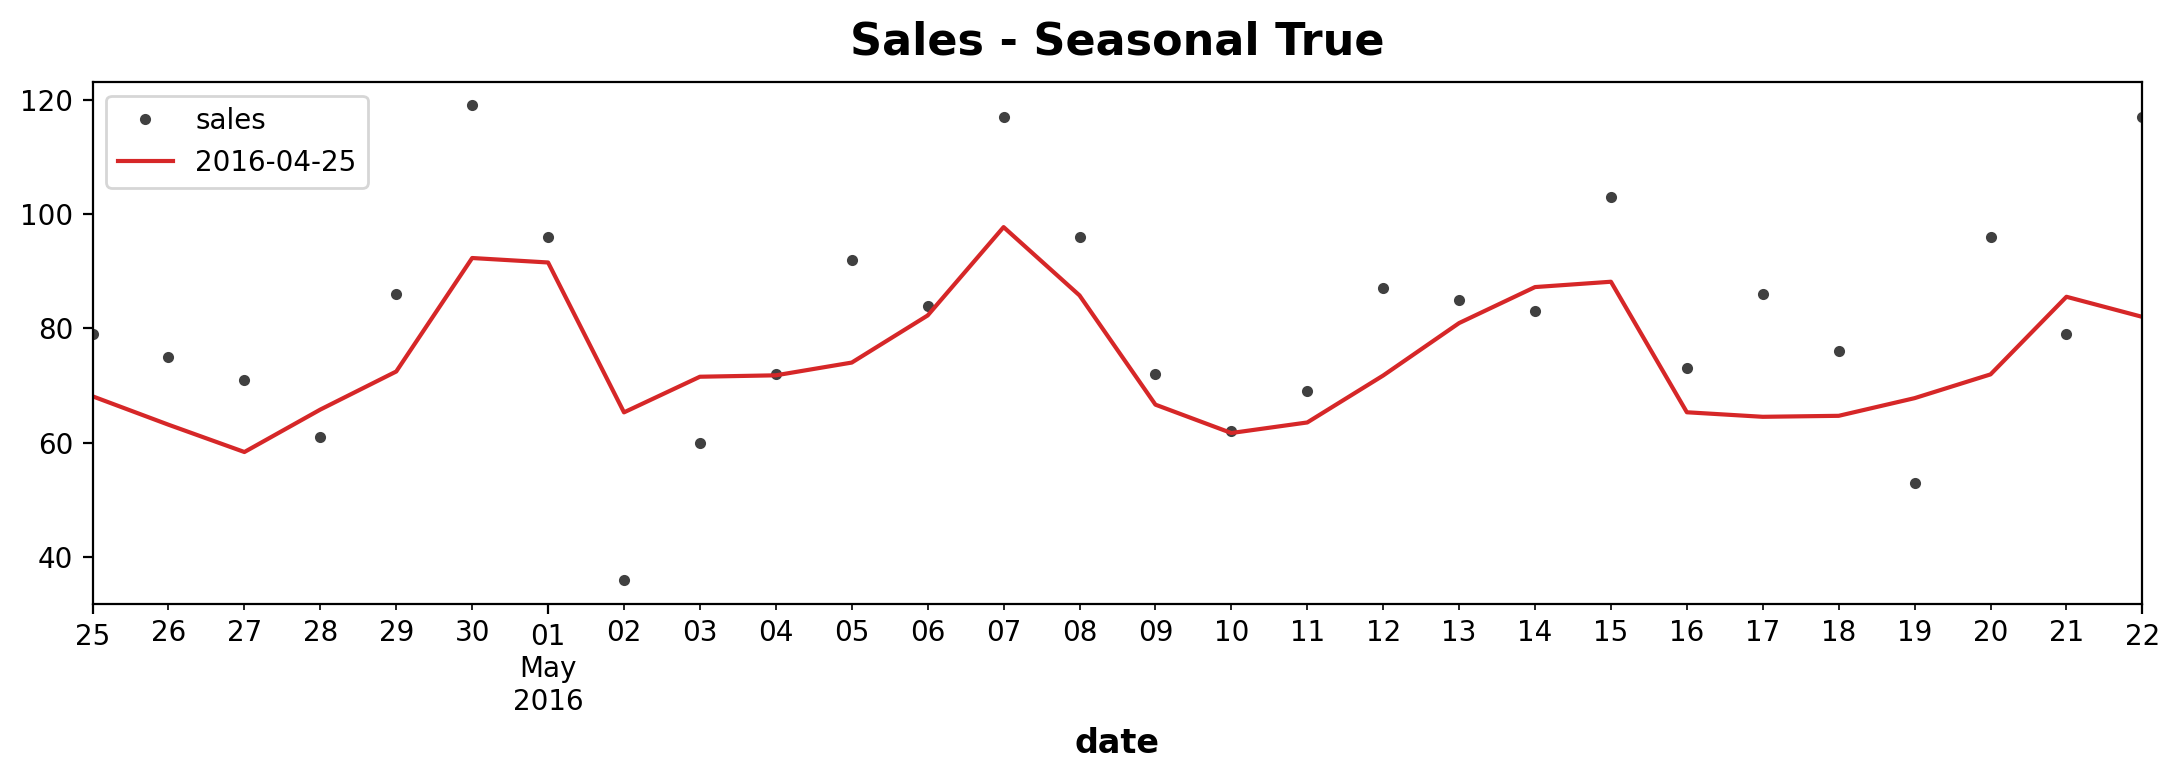

In [176]:
ax = valid_data.plot(color='0.25', style='.', title="Sales - Seasonal True")
ax = fore_data.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [180]:
fore_data.T

date,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,...,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22
date,,,,,,,,,,,,,,,,,,,,,
2016-04-25,68.123824,63.15325,58.37726,65.803392,72.463308,92.317156,91.536869,65.315465,71.547454,71.795916,...,80.937784,87.233472,88.167043,65.3312,64.537054,64.710826,67.802135,71.958801,85.537248,82.016186


### Predict All Items

In [192]:
%%time
day_columns = [column for column in train_data.columns if 'd_' in column]
y_fores = pd.DataFrame(columns=['id']+[f'F{i}' for i in range(1,29)])
loop = 0

lgb_params = {
    #"boosting_type": "goss",
    "n_estimators": 300,
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "metric": "rmse",
    "learning_rate": 0.01,
    "num_leaves": 2 ** 5 - 1,
    #"min_data_in_leaf": 2 ** 12 - 1,
    "feature_fraction": 0.5,
    #"max_bin": 100,
    "boost_from_average": False,
    #"num_boost_round": 1400,
    "verbose": -1,
    #"num_threads": os.cpu_count(),
    "force_row_wise": True,
    "seed": 42
}

for item_id in train_data['id'].unique():
    selected_item = train_data[train_data['id']==item_id]
    item_sales = selected_item[day_columns].sum()
    
    item_sales = item_sales.reset_index()
    item_sales['store_id'] = selected_item['store_id'].values[0]
    item_sales['item_id'] = selected_item['item_id'].values[0]
    
    item_sales = item_sales.rename({'index':'d', 0: 'sales'},axis=1)

    merged_item_sales = item_sales.merge(calendar, how='left', on='d')[['date', 'sales', 'store_id', 'item_id', 'wm_yr_wk']]

    merged_item_sales['date'] = pd.to_datetime(merged_item_sales['date'])
    merged_item_sales.set_index('date', inplace=True)
    merged_item_sales.index = merged_item_sales.index.to_period('D')
    
    merged_item_sales['sell_price'] = merged_item_sales.merge(price, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')['sell_price'].values

    fourier = CalendarFourier(freq='M', order=4)

    dp = DeterministicProcess(
        index=merged_item_sales.index,
        order=1,
        constant=True,
        seasonal=True,
        drop=True,   
        additional_terms=[fourier]
    )

    time_features = dp.in_sample()

    lag_features = make_lags(merged_item_sales.sales, lags=14)
    lag_features = lag_features.fillna(0.0)
    
    rolling_mean_features = make_rolling_mean(merged_item_sales.sales, lags=14, window=7)
    rolling_mean_features = rolling_mean_features.fillna(0.0)

    rolling_std_features = make_rolling_std(merged_item_sales.sales, lags=14, window=7)
    rolling_std_features = rolling_std_features.fillna(0.0)
    
    price_features = make_price_feature(merged_item_sales.sell_price)
    price_features = price_features.fillna(0)

    all_data = pd.concat([time_features, lag_features, rolling_mean_features, rolling_std_features, price_features], axis=1)
    all_data['sales'] = merged_item_sales['sales']
    
    all_data.rename({name: re.sub(r'[^a-zA-Z0-9_]', '_', name) for name in all_data.columns}, axis=1, inplace=True)

    y = make_multistep_target(all_data['sales'], steps=28).dropna()

    y, X = y.align(all_data[X_columns], join='inner', axis=0)
    #print(y)

    #model = LinearRegression()
    #model.fit(X, y)
    model = MultiOutputRegressor(lgb.LGBMRegressor(**lgb_params))
    model.fit(X, y)

    y_fore = pd.DataFrame(model.predict(all_data[X_columns][-1:]), columns=y.columns)
    y_fore['id'] = item_id
    y_fores = pd.concat([y_fores, y_fore], axis=0)
    
    loop += 1
    if loop % 1 == 0:
        print(f'{loop} done')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


<timed exec>:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


1 done
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
2 done
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


KeyboardInterrupt: 

In [191]:
len(train_data)

30490

In [194]:
all_data

,const,trend,s_2_7_,s_3_7_,s_4_7_,s_5_7_,s_6_7_,s_7_7_,sin_1_freq_M_,cos_1_freq_M_,...,price_rolling_std_6,price_rolling_std_7,price_rolling_max7,price_rolling_max14,price_rolling_max28,price_rolling_min7,price_rolling_min14,price_rolling_min28,price_change_ratio,sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.571268,0.820763,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
2011-01-30,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.394356,0.918958,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
2011-01-31,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.201299,0.979530,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
2011-02-01,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
2011-02-02,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.222521,0.974928,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,1.0,1937.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.299363,-0.954139,...,0.0,0.0,2.97,2.97,2.97,2.97,2.97,2.97,1.0,0
2016-05-19,1.0,1938.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.485302,-0.874347,...,0.0,0.0,2.97,2.97,2.97,2.97,2.97,2.97,1.0,2
2016-05-20,1.0,1939.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.651372,-0.758758,...,0.0,0.0,2.97,2.97,2.97,2.97,2.97,2.97,1.0,3


In [94]:
y_fores.to_csv('../result/evaluation_submission4.csv', index=False)

In [95]:
y_fores

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.661935,0.612812,0.743723,0.968304,0.895313,1.481757,1.218081,1.114698,1.439394,...,0.846474,0.933053,1.417140,1.112130,1.115184,0.986333,0.867337,0.825271,1.324736,1.239964
0,HOBBIES_1_002_CA_1_evaluation,0.393707,0.265822,0.157484,0.188148,0.217697,0.330499,0.428463,0.272021,0.155863,...,0.204927,0.141521,0.402948,0.308723,0.230889,0.276188,0.255005,0.277847,0.368197,0.326513
0,HOBBIES_1_003_CA_1_evaluation,0.994154,0.817212,0.856953,0.298960,0.601352,0.974771,1.281676,0.753925,0.502653,...,1.133348,1.216453,0.672867,0.913082,0.461400,0.482951,0.259900,0.903566,1.066832,0.934039
0,HOBBIES_1_004_CA_1_evaluation,3.617252,1.609514,1.202124,1.299567,1.342966,1.418200,2.599792,3.262439,1.901875,...,1.318766,1.285661,2.094164,2.888170,1.322872,1.413278,1.161817,1.340374,1.383718,2.428481
0,HOBBIES_1_005_CA_1_evaluation,1.431522,0.818567,0.853865,0.946014,0.750091,0.470884,1.261636,1.625526,1.093054,...,0.886435,0.909360,1.458630,1.623557,0.916353,0.575077,0.752390,0.829232,0.910703,1.531007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,FOODS_3_823_WI_3_evaluation,0.125793,0.432474,0.269753,0.535561,1.039902,0.204941,1.100433,0.721367,0.052094,...,1.022018,1.846191,0.534428,1.774139,1.365433,1.237183,0.551407,1.557526,1.768311,1.024734
0,FOODS_3_824_WI_3_evaluation,0.032745,-0.002136,0.228760,0.130920,-0.164429,-0.103714,-0.093189,-0.042768,0.055161,...,0.163589,-0.002594,0.036373,0.323578,0.152008,0.142609,0.364197,0.131096,0.202637,0.002186
0,FOODS_3_825_WI_3_evaluation,0.704330,0.599365,0.064499,0.174065,0.386157,0.435966,0.459373,-0.007538,0.136795,...,0.914803,0.743860,0.901042,1.060845,1.195403,0.770012,0.411057,0.810316,0.765793,0.740593
0,FOODS_3_826_WI_3_evaluation,1.283080,1.350679,1.273625,1.172211,1.078764,1.576730,1.444306,1.513017,1.053923,...,0.952738,1.188562,1.994330,1.587775,1.201539,1.251777,1.417038,1.284866,1.256331,1.545947


In [96]:
%%time
day_columns = [column for column in train_data.columns if 'd_' in column]
y_valids = pd.DataFrame(columns=['id']+[f'F{i}' for i in range(1,29)])
for item_id in train_data['id'].unique():
    selected_item = train_data[train_data['id']==item_id]
    item_sales = selected_item[day_columns].sum()
    item_sales.reset_index()
    item_sales = pd.DataFrame(item_sales, columns=['sales'])
    item_sales = item_sales.reset_index().rename({'index':'d'},axis=1)

    merged_item_sales = item_sales.merge(calendar, how='left', on='d')[['date', 'sales']]

    merged_item_sales['date'] = pd.to_datetime(merged_item_sales['date'])
    merged_item_sales.set_index('date', inplace=True)
    merged_item_sales.index = merged_item_sales.index.to_period('D')


    y = make_multistep_target(merged_item_sales['sales'], steps=28).dropna()
    y_valid = y[-1:].copy()
    y_valid['id'] = item_id.replace('_evaluation', '_validation')

    y_valids = pd.concat([y_valids, y_valid], axis=0)

<timed exec>:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
<timed exec>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


CPU times: user 2min 29s, sys: 1.72 s, total: 2min 31s
Wall time: 2min 31s


In [97]:
y_valids.to_csv('../result/validation_submission4.csv', index=False)

In [98]:
all_sub = pd.concat([y_valids, y_fores], axis=0)

In [99]:
all_sub.to_csv('../result/submission4.csv', index=False)